In [97]:
import numpy as np
import matplotlib.pyplot as plt

In [98]:
import torch
from torch import nn
from torch.utils.data import DataLoader,dataset

In [99]:
from torchvision.transforms import ToTensor,Lambda
from torchvision.datasets import FashionMNIST

<h3>Downloading and preparing data</h3>

In [100]:
train_set = FashionMNIST(
    root = "datasets",
    download= True,
    train = True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y : torch.zeros(10, dtype = torch.float).scatter_(0,torch.tensor(y),value = 1))
)

In [101]:
test_set = FashionMNIST(
    root = "datasets",
    download= True,
    train = False,
    transform=ToTensor(),
    target_transform = Lambda(lambda y : torch.zeros(10, dtype = torch.float).scatter_(0,torch.tensor(y),value = 1))
)

In [102]:
print(train_set.__getitem__(10)[1])
print(test_set.__getitem__(3)[1])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [112]:
def show_sample(set : dataset,inds : list, n : int =  4, predicted : list = None):

    names_dict = set.class_to_idx
    
    def get_key(dc,target):
        for key in dc.keys():
            if dc[key] == target:
                return key

    fig = plt.figure(figsize = (n,n))
    for i in range(n**2):
        ax = fig.add_subplot(n,n,i+1)
        if i < len(inds):
            img_info = set.__getitem__(inds[i])
            ax.imshow(img_info[0].numpy()[0],cmap = "inferno",alpha = 0.7)
            title = f"{get_key(names_dict,img_info[1].argmax())}" 
            if predicted != None and i < len(predicted):
                title += f"\n{get_key(names_dict,predicted[i])}"
            ax.set_title(title)
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()        
    return fig

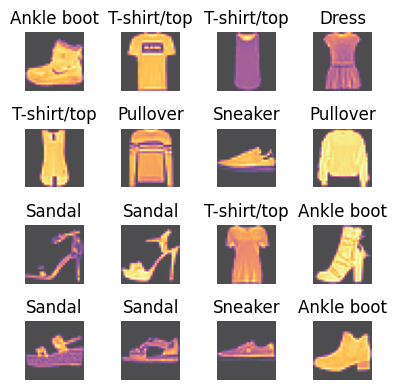

In [113]:
fig = show_sample(train_set,[i for i in range(16)],4)

In [105]:
train_dl = DataLoader(train_set, batch_size = 41, shuffle = True)
test_dl = DataLoader(test_set, batch_size = 16, shuffle=True)

<h3>Preparing model for presentation</h3>

In [106]:
# we have to determine the size of theinput data

_,n,m = train_dl.dataset.__getitem__(0)[0].shape
print(n,m)

labels = train_dl.dataset.class_to_idx
print(labels)
print(len(labels))

28 28
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
10


In [107]:
class DenseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flattering = nn.Flatten()
        self.DenseLayer = nn.Sequential(
            nn.Linear(n * m , 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,10)
        )

    def forward(self,x):
        x = self.flattering(x)
        x = self.DenseLayer(x)
        return x

In [110]:
model = DenseNN()
lr = 1e-3
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [128]:
def training_loop(dataloader,model,loss,optimizer):
    avgd_loss = 0.
    avgd_accuracy = 0.
    batches = len(dataloader)

    for _, (X, y) in enumerate(dataloader):
        size = len(X)

        logits = model(X)
        pred = nn.Softmax(dim = 1)(logits)
        loss_val = loss(pred,y)

        loss_val.backward()
        optimizer.step()
        optimizer.zero_grad()

        avgd_loss += loss_val.item()
        with torch.inference_mode():
            avgd_accuracy += (pred.argmax() == y).sum() / size
 
    return avgd_loss / batches, avgd_accuracy / batches


def testing_loop(dataloader,model,loss):
    avgd_loss = 0.
    avgd_accuracy = 0.
    batches = len(dataloader)

    for _, (X, y) in enumerate(dataloader):
        with torch.inference_mode():
            size = len(X)

            logits = model(X)
            pred = nn.Softmax(dim = 1)(logits)
            loss_val = loss(pred,y)

            avgd_loss += loss_val.item()
            avgd_accuracy += (pred.argmax() == y).sum() / size

    return avgd_loss / batches, avgd_accuracy / batches

        

In [129]:
epochs = 100

loss_arr_train = []
accuracy_arr_train = []
loss_arr_test = []
accuracy_arr_test = []

for epoch in range(epochs):
    loss_train,acc_train = training_loop(train_dl,model,loss,optimizer)
    loss_test,acc_test = testing_loop(test_dl,model,loss)
    print(f"epoch: {epoch}/{epochs}" + "-" * 10)
    print(f"training set:")
    print(f"accuracy: {acc_train}, loss: {loss_train}")
    print(f"accuracy: {acc_test}, loss: {loss_test}")


epoch: 0/100----------
training set:
accuracy: 0.1598360687494278, loss: 2.294075662646789
accuracy: 0.5472000241279602, loss: 2.2929349670410155
epoch: 1/100----------
training set:
accuracy: 0.2643442749977112, loss: 2.2915402071072104
accuracy: 0.41760000586509705, loss: 2.290166971206665
epoch: 2/100----------
training set:
accuracy: 0.1844262331724167, loss: 2.2884489750601555
accuracy: 0.3312000036239624, loss: 2.286745384979248
epoch: 3/100----------
training set:
accuracy: 0.1844262331724167, loss: 2.2845781805411063
accuracy: 0.3887999951839447, loss: 2.2824075637817383
epoch: 4/100----------
training set:
accuracy: 0.1905737668275833, loss: 2.279602690472629
accuracy: 0.36000001430511475, loss: 2.276756760406494
epoch: 5/100----------
training set:
accuracy: 0.12295082211494446, loss: 2.272980606946789
accuracy: 0.15839999914169312, loss: 2.2690551708221434
epoch: 6/100----------
training set:
accuracy: 0.06762295216321945, loss: 2.2636039327076873
accuracy: 0.028799999505281

KeyboardInterrupt: 